<a href="https://colab.research.google.com/github/lucasresck/nlp/blob/master/bert_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of texts using BERT

Inspired by: https://colab.research.google.com/github/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb

## Setup

In [1]:
!pip install -q tf-models-official==2.3.0

In [2]:
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

tfds.disable_progress_bar()

In [3]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [4]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [5]:
DATAPATH = 'drive/My Drive/Colab Notebooks/data'

## Data

### Load data

In [6]:
filenames = os.listdir(os.path.join(DATAPATH, 'cbr-ilp-ir-son-int'))
corpus = []
for filename in tqdm(filenames):
    with open(os.path.join(DATAPATH, 'cbr-ilp-ir-son-int', filename), 'r', encoding='latin-1') as f:
        corpus.append(f.read())

In [7]:
classes = [(filename.split('-')[0]).split('_')[0] for filename in filenames]
which_class = dict(zip(set(classes), range(5)))
y = np.array([which_class[name] for name in classes])

### Split training, evaluation and test data

In [8]:
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, random_state=2020, test_size=0.2)
corpus_train, corpus_eval, y_train, y_eval = train_test_split(corpus_train, y_train, random_state=2021, test_size=0.2)

### Preprocess data

In [9]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))[:100]
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(corpus):
  num_examples = len(corpus)
  
  sentences = tf.ragged.constant([
      encode_sentence(s)
      for s in corpus])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentences.shape[0]
  input_word_ids = tf.concat([cls, sentences], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.ones_like(sentences)
  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [10]:
papers_train = bert_encode(corpus_train)
papers_train_labels = tf.constant(y_train)

papers_eval = bert_encode(corpus_eval)
papers_eval_labels = tf.constant(y_eval)

papers_test = bert_encode(corpus_test)
papers_test_labels = tf.constant(y_test)

In [11]:
for key, value in papers_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'papers_train_labels shape: {papers_train_labels.shape}')

input_word_ids  shape: (435, 102)
input_mask      shape: (435, 102)
input_type_ids  shape: (435, 102)
papers_train_labels shape: (435,)


## The model

In [12]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [13]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, hub_module_url=hub_url_bert, num_labels=len(set(classes)))

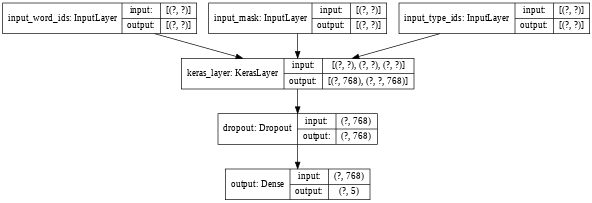

In [14]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

### Example of classification

In [15]:
papers_batch = {key: val[:10] for key, val in papers_train.items()}

bert_classifier(
    papers_batch, training=True
).numpy()

array([[ 0.43066475,  0.67105615,  0.17031476, -0.04501677, -0.06970296],
       [ 0.40447897,  0.48438317,  0.27324286, -0.13936776, -0.08861032],
       [ 0.38168758,  0.39743164,  0.2794752 , -0.19226956, -0.19593948],
       [ 0.2600276 ,  0.44643486,  0.3068444 ,  0.0282186 , -0.18142663],
       [ 0.35779053,  0.74806154,  0.3032358 , -0.44590965, -0.29897273],
       [ 0.16474795,  0.50578254,  0.17412302, -0.34160185,  0.05735749],
       [ 0.32797325,  0.46726137, -0.03767957,  0.07068426, -0.2660399 ],
       [ 0.26063955,  0.6782309 ,  0.16483453, -0.3296475 , -0.07968827],
       [ 0.30134702,  0.55034274,  0.0668944 ,  0.02624078, -0.22295086],
       [ 0.3602987 ,  0.47127804,  0.31340578, -0.05040336, -0.15523338]],
      dtype=float32)

### Fine-tuning

In [16]:
# Set up epochs and steps
epochs = 3
batch_size = 32

train_data_size = len(papers_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [17]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      papers_train, papers_train_labels,
      validation_data=(papers_eval, papers_eval_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
14/14 [==============================] - 473s 34s/step - loss: 1.5280 - accuracy: 0.2943 - val_loss: 1.3459 - val_accuracy: 0.4587
Epoch 2/3
14/14 [==============================] - 471s 34s/step - loss: 1.3046 - accuracy: 0.4161 - val_loss: 1.1690 - val_accuracy: 0.4587
Epoch 3/3
14/14 [==============================] - 472s 34s/step - loss: 1.1684 - accuracy: 0.4759 - val_loss: 1.1143 - val_accuracy: 0.5046


## Evaluate model

In [27]:
# Training data
result = bert_classifier(papers_train, training=False)
np.sum(tf.argmax(result, axis=1) == papers_train_labels)/len(papers_train_labels)

0.5609195402298851

In [28]:
# Test data
result = bert_classifier(papers_test, training=False)
np.sum(tf.argmax(result, axis=1) == papers_test_labels)/len(papers_test_labels)

0.5109489051094891

The model isn't yet fine-tuned.